# Summary of PySINDy YouTube tutorial videos

This notebook is a summary of the PySINDy YouTube lectures found [here](https://www.youtube.com/playlist?list=PLN90bHJU-JLoOfEk0KyBs2qLTV7OkMZ25). 
An interactive version of this notebook is available on binder
[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/dynamicslab/pysindy/v1.5.1?filepath=examples/15_pysindy_lectures.ipynb)

These examples show how to use the SINDy method in practice, addressing the following practical questions:
1. #### How does one choose the thresholding parameter $\lambda$?
2. #### How to make SINDy more robust? <br>
    a) Smoothing and more robust derivatives <br>
    b) More data through multiple trajectories <br>
    c) Physical priors with model constraints <br>
    d) Provably stable models with Trapping SINDy <br>
    e) Ensemble methods <br>
    f) Weak-formulation SINDy <br>
3. #### How to handle equations beyond systems of ODES? <br>
    a) Implicit ODEs with SINDy-PI <br>
    b) PDEs with PDE-FIND <br>
4. #### How to choose a regularizer and a sparse regression algorithm?
5. #### How to build tailored candidate libraries?

An interactive version of this notebook is available on binder.

#### Load in dependencies and define a number of plotting functions for use later

In [1]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from IPython.display import Image
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from scipy.integrate import solve_ivp
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Ridge
from sklearn.linear_model import OrthogonalMatchingPursuit
from sklearn.linear_model import Lars
from sklearn.linear_model import LassoLars

from pysindy.utils import lorenz, lorenz_control, enzyme
import pysindy as ps

# bad code but allows us to ignore warnings
import warnings
from scipy.integrate.odepack import ODEintWarning
warnings.simplefilter("ignore", category=UserWarning)
warnings.simplefilter("ignore", category=FutureWarning)
warnings.simplefilter("ignore", category=ODEintWarning)

In [2]:
# Seed the random number generators for reproducibility
np.random.seed(100)

# Initialize integrator keywords for solve_ivp to replicate the odeint defaults
integrator_keywords = {}
integrator_keywords['rtol'] = 1e-12
integrator_keywords['method'] = 'LSODA'
integrator_keywords['atol'] = 1e-12

In [3]:
from scipy.integrate import trapezoid
from scipy.interpolate import interp1d


# Make coefficient plot for threshold scan
def plot_pareto(coefs, opt, model, threshold_scan, x_test, t_test):
    dt = t_test[1] - t_test[0]
    mse = np.zeros(len(threshold_scan))
    mse_sim = np.zeros(len(threshold_scan))
    for i in range(len(threshold_scan)):
        opt.coef_ = coefs[i]
        mse[i] = model.score(x_test, t=dt, metric=mean_squared_error)
        x_test_sim = model.simulate(x_test[0, :], t_test, integrator="odeint")
        if np.any(x_test_sim > 1e4):
            x_test_sim = 1e4
        mse_sim[i] = np.sum((x_test - x_test_sim) ** 2)
    plt.figure()
    plt.semilogy(threshold_scan, mse, "bo")
    plt.semilogy(threshold_scan, mse, "b")
    plt.ylabel(r"$\dot{X}$ RMSE", fontsize=20)
    plt.xlabel(r"$\lambda$", fontsize=20)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.grid(True)
    plt.figure()
    plt.semilogy(threshold_scan, mse_sim, "bo")
    plt.semilogy(threshold_scan, mse_sim, "b")
    plt.ylabel(r"$\dot{X}$ RMSE", fontsize=20)
    plt.xlabel(r"$\lambda$", fontsize=20)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.grid(True)


# Make plots of the data and its time derivative
def plot_data_and_derivative(x, dt, deriv):
    feature_name = ["x", "y", "z"]
    plt.figure(figsize=(20, 5))
    for i in range(3):
        plt.subplot(1, 3, i + 1)
        plt.plot(x[:, i], label=feature_name[i])
        plt.grid(True)
        plt.xlabel("t", fontsize=24)
        plt.xticks(fontsize=18)
        plt.yticks(fontsize=18)
        plt.legend(fontsize=24)
    x_dot = deriv(x, t=dt)
    plt.figure(figsize=(20, 5))
    for i in range(3):
        plt.subplot(1, 3, i + 1)
        plt.plot(x_dot[:, i], label=r"$\dot{" + feature_name[i] + "}$")
        plt.grid(True)
        plt.xlabel("t", fontsize=24)
        plt.xticks(fontsize=18)
        plt.yticks(fontsize=18)
        plt.legend(fontsize=24)


# Make an errorbar coefficient plot from the results of ensembling
def plot_ensemble_results(
    model, mean_ensemble, std_ensemble, mean_library_ensemble, std_library_ensemble
):
    # Plot results
    xticknames = model.get_feature_names()
    for i in range(10):
        xticknames[i] = "$" + xticknames[i] + "$"
    plt.figure(figsize=(18, 4))
    colors = ["b", "r", "k"]
    plt.subplot(1, 2, 1)
    plt.xlabel("Candidate terms", fontsize=22)
    plt.ylabel("Coefficient values", fontsize=22)
    for i in range(3):
        plt.errorbar(
            range(10),
            mean_ensemble[i, :],
            yerr=std_ensemble[i, :],
            fmt="o",
            color=colors[i],
            label=r"Equation for $\dot{" + feature_names[i] + r"}$",
        )
    ax = plt.gca()
    plt.grid(True)
    ax.set_xticks(range(10))
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    ax.set_xticklabels(xticknames, verticalalignment="top")
    plt.subplot(1, 2, 2)
    plt.xlabel("Candidate terms", fontsize=22)
    for i in range(3):
        plt.errorbar(
            range(10),
            mean_library_ensemble[i, :],
            yerr=std_library_ensemble[i, :],
            fmt="o",
            color=colors[i],
            label=r"Equation for $\dot{" + feature_names[i] + r"}$",
        )
    ax = plt.gca()
    plt.grid(True)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.legend(fontsize=16, loc="upper right")
    ax.set_xticks(range(10))
    ax.set_xticklabels(xticknames, verticalalignment="top")


# Make energy-preserving quadratic constraints for model of size r
def make_constraints(r):
    q = 0
    N = int((r ** 2 + 3 * r) / 2.0)
    p = r + r * (r - 1) + int(r * (r - 1) * (r - 2) / 6.0)
    constraint_zeros = np.zeros(p)
    constraint_matrix = np.zeros((p, r * N))

    # Set coefficients adorning terms like a_i^3 to zero
    for i in range(r):
        constraint_matrix[q, r * (N - r) + i * (r + 1)] = 1.0
        q = q + 1

    # Set coefficients adorning terms like a_ia_j^2 to be antisymmetric
    for i in range(r):
        for j in range(i + 1, r):
            constraint_matrix[q, r * (N - r + j) + i] = 1.0
            constraint_matrix[
                q, r * (r + j - 1) + j + r * int(i * (2 * r - i - 3) / 2.0)
            ] = 1.0
            q = q + 1
    for i in range(r):
        for j in range(0, i):
            constraint_matrix[q, r * (N - r + j) + i] = 1.0
            constraint_matrix[
                q, r * (r + i - 1) + j + r * int(j * (2 * r - j - 3) / 2.0)
            ] = 1.0
            q = q + 1

    # Set coefficients adorning terms like a_ia_ja_k to be antisymmetric
    for i in range(r):
        for j in range(i + 1, r):
            for k in range(j + 1, r):
                constraint_matrix[
                    q, r * (r + k - 1) + i + r * int(j * (2 * r - j - 3) / 2.0)
                ] = 1.0
                constraint_matrix[
                    q, r * (r + k - 1) + j + r * int(i * (2 * r - i - 3) / 2.0)
                ] = 1.0
                constraint_matrix[
                    q, r * (r + j - 1) + k + r * int(i * (2 * r - i - 3) / 2.0)
                ] = 1.0
                q = q + 1

    return constraint_zeros, constraint_matrix


# For Trapping SINDy, use optimal m, and calculate if identified model is stable
def check_stability(r, Xi, sindy_opt):
    N = int((r ** 2 + 3 * r) / 2.0)
    opt_m = sindy_opt.m_history_[-1]
    PL_tensor_unsym = sindy_opt.PL_unsym_
    PL_tensor = sindy_opt.PL_
    PQ_tensor = sindy_opt.PQ_
    mPQ = np.tensordot(opt_m, PQ_tensor, axes=([0], [0]))
    P_tensor = PL_tensor - mPQ
    As = np.tensordot(P_tensor, Xi, axes=([3, 2], [0, 1]))
    eigvals, eigvecs = np.linalg.eigh(As)
    print("optimal m: ", opt_m)
    print("As eigvals: ", np.sort(eigvals))
    print(
        "All As eigenvalues are < 0 and therefore system is globally stable? ",
        np.all(eigvals < 0),
    )
    max_eigval = np.sort(eigvals)[-1]
    min_eigval = np.sort(eigvals)[0]
    L = np.tensordot(PL_tensor_unsym, Xi, axes=([3, 2], [0, 1]))
    Q = np.tensordot(PQ_tensor, Xi, axes=([4, 3], [0, 1]))
    d = np.dot(L, opt_m) + np.dot(np.tensordot(Q, opt_m, axes=([2], [0])), opt_m)
    Rm = np.linalg.norm(d) / np.abs(max_eigval)
    print("Estimate of trapping region size, Rm = ", Rm)


# Plot Kuramoto-Sivashinsky data and its derivative
def plot_u_and_u_dot(t, x, u):
    dt = t[1] - t[0]
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.pcolormesh(t, x, u[:, :, 0])
    plt.xlabel("t", fontsize=16)
    plt.ylabel("x", fontsize=16)
    plt.title(r"$u(x, t)$", fontsize=16)
    u_dot = ps.FiniteDifference(axis=1)._differentiate(u, t=dt)
    plt.subplot(1, 2, 2)
    plt.pcolormesh(t, x, u_dot[:, :, 0])
    plt.xlabel("t", fontsize=16)
    plt.ylabel("x", fontsize=16)
    ax = plt.gca()
    ax.set_yticklabels([])
    plt.title(r"$\dot{u}(x, t)$", fontsize=16)
    plt.show()
    return u_dot


# function stolen from Example 11 Jupyter notebook to plot greedy algorithm progress
def plot_x_dot_fits(x_test, optimizer, dt, n_models):
    plt.figure(figsize=(20, 6))
    gs = gridspec.GridSpec(3, n_models)
    gs.update(wspace=0.0, hspace=0.0)  # set the spacing between axes.
    for j in range(n_models):
        optimizer.coef_ = np.asarray(optimizer.history_)[j, :, :]

        # Predict derivatives using the learned model
        x_dot_test_predicted = model.predict(x_test)

        # Compute derivatives with a finite difference method, for comparison
        x_dot_test_computed = model.differentiate(x_test, t=dt)

        for i in range(3):
            plt.subplot(gs[i, j])
            plt.plot(
                t_test, x_dot_test_computed[:, i], "k", 
                label="numerical derivative"
            )
            plt.plot(t_test, x_dot_test_predicted[:, i], "r", 
                     label="model prediction")
            if j == 0:
                plt.ylabel("$\dot " + feature_names[i] + r"$", fontsize=20)
            if i == 0:
                plt.title(
                    "MSE = %.0f" % model.score(x_test, 
                                               t=dt, 
                                               metric=mean_squared_error),
                    fontsize=16,
                )
            plt.xlabel("Iteration " + str(j), fontsize=16)
            plt.xticks(fontsize=18)
            plt.yticks(fontsize=18)
            ax = plt.gca()
            ax.set_xticklabels([])
            ax.set_yticklabels([])
            plt.grid(True)

        if j == np.asarray(optimizer.history_).shape[0] - 1:
            break
    ax.set_yticklabels([])
    plt.show()


# function stolen from Example 11 Jupyter notebook to plot greedy algorithm progress
def plot_x_fits(x_test, optimizer, t_test, n_models):
    plt.figure(figsize=(20, 6))
    gs = gridspec.GridSpec(3, n_models)
    gs.update(wspace=0.0, hspace=0.0)  # set the spacing between axes.
    for j in range(n_models):
        optimizer.coef_ = np.asarray(optimizer.history_)[j, :, :]

        # Simulate dynamic system with the identified model
        # Some of these models may diverge, so need to use odeint
        # rather than the default solve_ivp, which crashes with an error
        x_test_sim = model.simulate(x_test[0, :], t_test, integrator="odeint")

        for i in range(3):
            plt.subplot(gs[i, j])
            plt.plot(t_test, x_test[:, i], "k", label="test trajectory")
            if np.max(np.abs(x_test_sim[:, i])) < 1000:  # check for unstable systems
                plt.plot(t_test, x_test_sim[:, i], "r", label="model prediction")
            if j == 0:
                plt.ylabel(feature_names[i], fontsize=20)
            plt.xlabel("Iteration " + str(j), fontsize=16)
            plt.xticks(fontsize=18)
            plt.yticks(fontsize=18)
            ax = plt.gca()
            ax.set_xticklabels([])
            ax.set_yticklabels([])
            plt.grid(True)

        if j == np.asarray(optimizer.history_).shape[0] - 1:
            break
    ax.set_yticklabels([])
    plt.show()


# Make 3d plots comparing a test trajectory, 
# an associated model trajectory, and a second model trajectory.
def make_3d_plots(x_test, x_sim, constrained_x_sim, last_label):
    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111, projection="3d")
    plt.plot(
        x_test[:, 0],
        x_test[:, 1],
        x_test[:, 2],
        "k",
        label="Validation Lorenz trajectory",
    )
    plt.plot(x_sim[:, 0], x_sim[:, 1], x_sim[:, 2], "r", 
             label="SR3, no constraints")
    plt.plot(
        constrained_x_sim[:, 0],
        constrained_x_sim[:, 1],
        constrained_x_sim[:, 2],
        "b",
        label=last_label,
    )
    ax.set_xlabel("x", fontsize=20)
    ax.set_ylabel("y", fontsize=20)
    ax.set_zlabel("z", fontsize=20)
    plt.legend(fontsize=16, framealpha=1.0)
    plt.show()

## Lorenz system
We will use the famous Lorenz system for most of the examples below:
$$ \dot{x} = \sigma (y - x),$$
$$ \dot{y} = x(\rho - z) - y, $$
$$ \dot{z} = x y - \beta z, $$
with $\sigma = 10$, $\rho = 28$, and $\beta = 8/3$.

In [4]:
# define the testing and training Lorenz data we will use for these examples
dt = 0.002

t_train = np.arange(0, 10, dt)
x0_train = [-8, 8, 27]
t_train_span = (t_train[0], t_train[-1])
x_train = solve_ivp(
    lorenz, t_train_span, x0_train, t_eval=t_train, **integrator_keywords
).y.T

t_test = np.arange(0, 15, dt)
t_test_span = (t_test[0], t_test[-1])
x0_test = np.array([8, 7, 15])
x_test = solve_ivp(
    lorenz, t_test_span, x0_test, t_eval=t_test, **integrator_keywords
).y.T

# define the testing and training data for the Lorenz system with control
def u_fun(t):
    return np.column_stack([np.sin(2 * t), t ** 2])


x_train_control = solve_ivp(
    lorenz_control,
    t_train_span,
    x0_train,
    t_eval=t_train,
    args=(u_fun,),
    **integrator_keywords
).y.T
u_train_control = u_fun(t_train)
x_test_control = solve_ivp(
    lorenz_control,
    t_test_span,
    x0_test,
    t_eval=t_test,
    args=(u_fun,),
    **integrator_keywords
).y.T
u_test_control = u_fun(t_test)

# Part 1: How to choose algorithm hyperparameters such as $\lambda$?

In [5]:
# Instantiate and fit the SINDy model
feature_names = ['x', 'y', 'z']
sparse_regression_optimizer = ps.STLSQ(threshold=0)  # default is lambda = 0.1
model = ps.SINDy(feature_names=feature_names, optimizer=sparse_regression_optimizer)
model.fit(x_train, t=dt)
model.print()

(x)' = -0.001 1 + -10.005 x + 10.003 y
(y)' = -0.015 1 + 27.991 x + -0.998 y + 0.002 z + -1.000 x z
(z)' = 0.008 1 + 0.006 x + -0.004 y + -2.666 z + 0.001 x^2 + 0.999 x y


In [6]:
sparse_regression_optimizer = ps.STLSQ(threshold=0.1)
model = ps.SINDy(feature_names=feature_names, optimizer=sparse_regression_optimizer)
model.fit(x_train, t=dt)
model.print()

(x)' = -9.999 x + 9.999 y
(y)' = 27.992 x + -0.999 y + -1.000 x z
(z)' = -2.666 z + 1.000 x y


In [7]:
sparse_regression_optimizer = ps.STLSQ(threshold=1.0)
model = ps.SINDy(feature_names=feature_names, optimizer=sparse_regression_optimizer)
model.fit(x_train, t=dt)
model.print()

(x)' = -9.999 x + 9.999 y
(y)' = -2.793 x
(z)' = 0.000


/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:176: UserWarning: Sparsity parameter is too big (1.0) and eliminated all coefficients
  "coefficients".format(self.threshold)


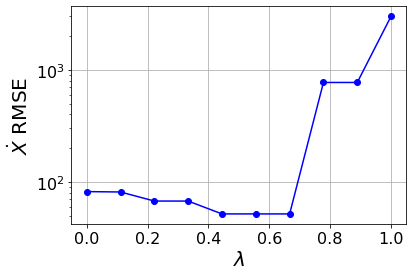

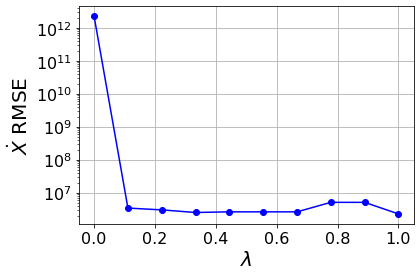

In [8]:
threshold_scan = np.linspace(0, 1.0, 10)
coefs = []
rmse = mean_squared_error(x_train, np.zeros(x_train.shape), squared=False)
x_train_added_noise = x_train + np.random.normal(0, rmse / 10.0,  x_train.shape)
for i, threshold in enumerate(threshold_scan):
    sparse_regression_optimizer = ps.STLSQ(threshold=threshold)
    model = ps.SINDy(feature_names=feature_names, 
                     optimizer=sparse_regression_optimizer)
    model.fit(x_train_added_noise, t=dt, quiet=True)
    coefs.append(model.coefficients())
    
plot_pareto(coefs, sparse_regression_optimizer, model, 
            threshold_scan, x_test, t_test)

### Primary conclusions of part 1 
A type of pareto curve, generated by scanning over $\lambda$, produces a systematic way to choose the level of sparsity in a system.
Moreover, there are sharp increases as $\lambda$ increases. There are physical dropoffs because these correspond to important terms being truncated off the model!

# Part 2: How to make SINDy more robust for system identification?

### Part 2a: Differentiate the data with method other than finite differences!
First, let's look at what's wrong with finite differences

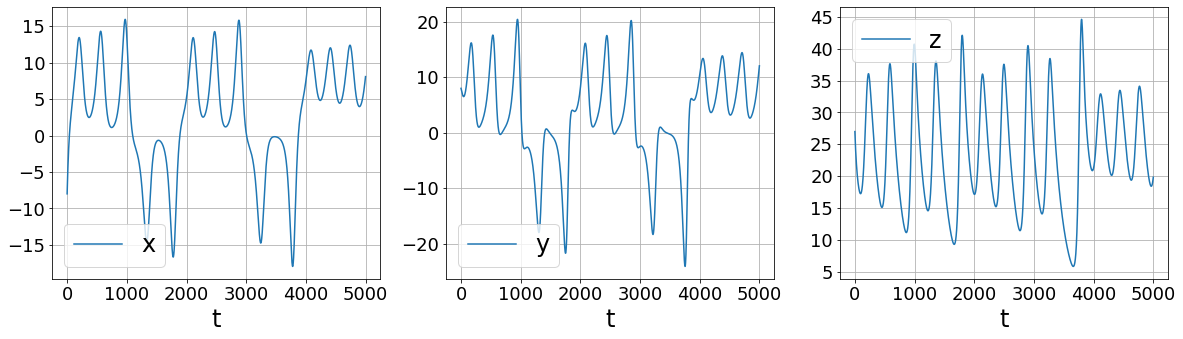

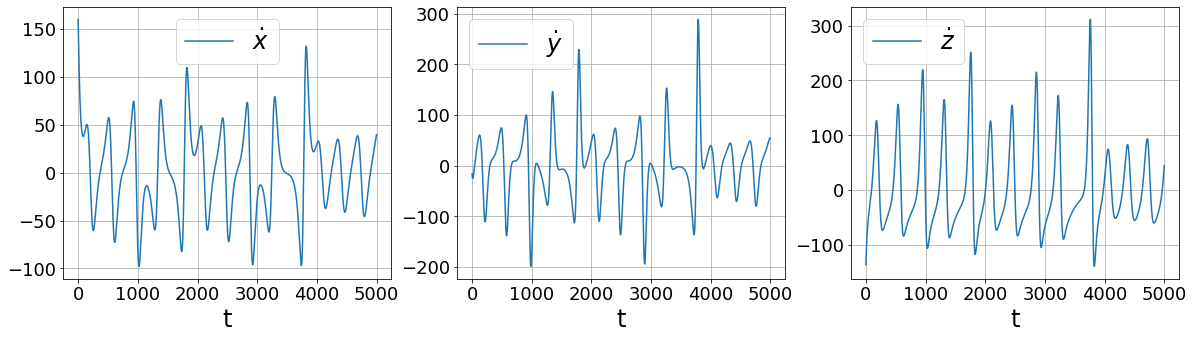

In [9]:
rmse = mean_squared_error(x_train, np.zeros(x_train.shape), squared=False)
x_train_added_noise = x_train 
plot_data_and_derivative(x_train_added_noise, dt, 
                         ps.FiniteDifference()._differentiate)

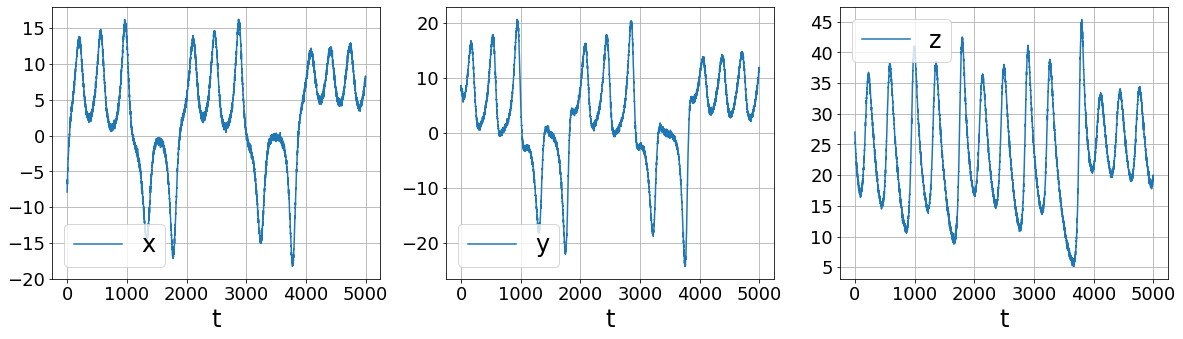

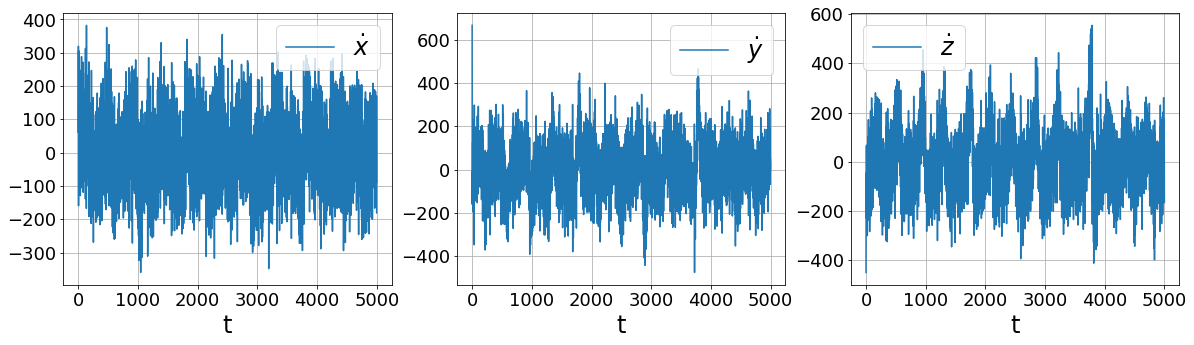

In [10]:
# 2% added noise
rmse = mean_squared_error(x_train, np.zeros(x_train.shape), squared=False)
x_train_added_noise = x_train + np.random.normal(0, rmse / 50.0,  x_train.shape)
plot_data_and_derivative(x_train_added_noise, dt, 
                         ps.FiniteDifference()._differentiate)

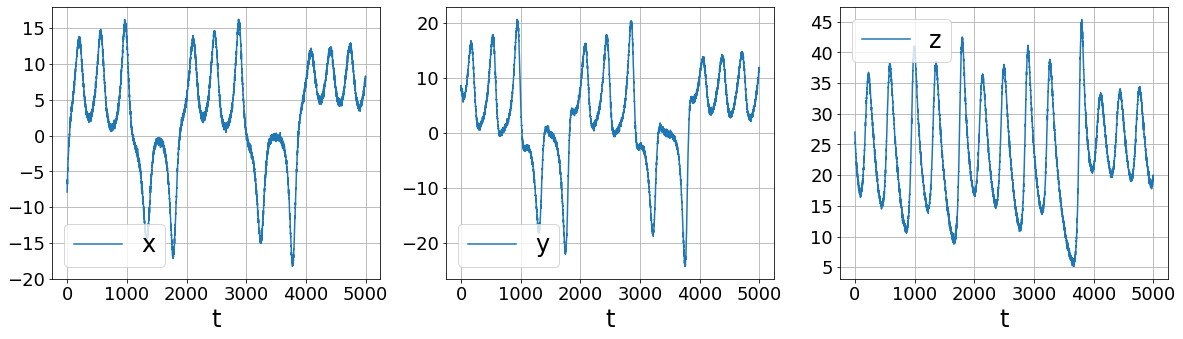

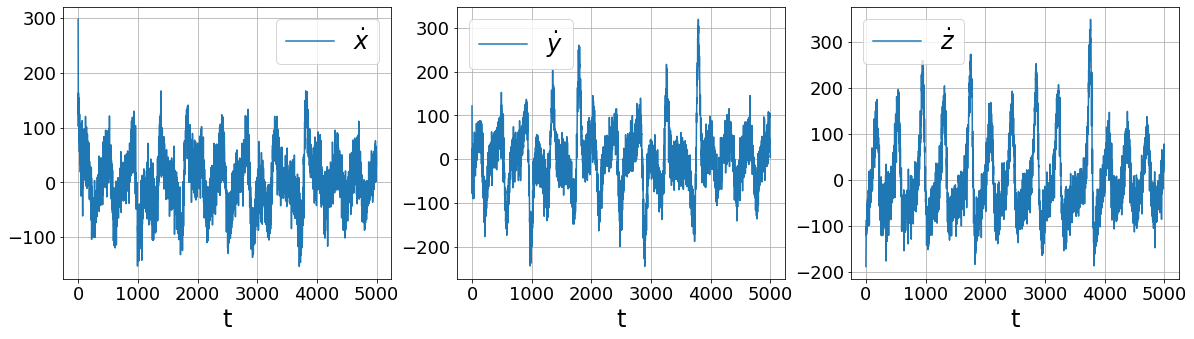

In [11]:
# Repeat but with smoothed finite differences!
plot_data_and_derivative(x_train_added_noise, dt, 
                         ps.SmoothedFiniteDifference()._differentiate)

### Primary conclusions of part 2a
More sophisticated numerical differentiation can avoid some of the noise amplification associated with finite differences.
While we only look at using a simple SmoothedFiniteDifference class, there are many other differentiatiors available in PySINDy. See the Example 5 Jupyter notebook for more details.

### Part 2b: Simply add more data!

In [12]:
sparse_regression_optimizer = ps.STLSQ()
model = ps.SINDy(feature_names=feature_names, optimizer=sparse_regression_optimizer)
model.fit(x_train_added_noise, t=dt)
model.print()

(x)' = -9.922 x + 9.932 y
(y)' = 0.336 1 + 26.918 x + -0.637 y + -0.977 x z
(z)' = -2.670 z + 1.000 x y


In [13]:
n_trajectories = 40
x0s = (np.random.rand(n_trajectories, 3) - 0.5) * 20
x_train_multi = []
for i in range(n_trajectories):
    x_train_temp = solve_ivp(
        lorenz, t_train_span, x0s[i], t_eval=t_train, **integrator_keywords
    ).y.T
    rmse = mean_squared_error(x_train_temp, 
                              np.zeros(x_train_temp.shape), 
                              squared=False)
    x_train_multi.append(
        x_train_temp + np.random.normal(0, rmse / 50.0, x_train_temp.shape)
    )

sparse_regression_optimizer = ps.STLSQ()
model = ps.SINDy(feature_names=feature_names, optimizer=sparse_regression_optimizer)
model.fit(x_train_multi, t=dt, multiple_trajectories=True)
model.print()

(x)' = -9.874 x + 9.886 y
(y)' = 27.590 x + -0.867 y + -0.991 x z
(z)' = -0.432 1 + -2.643 z + 0.997 x y


### Primary conclusions of part 2b
Even when all the data is noisy, often model improvements are available by simply adding more data to the regression. 

### Part 2c: Use ensemble methods

In [14]:
# Fit a regular SINDy model with 5% added Gaussian noise
rmse = mean_squared_error(x_train, np.zeros(x_train.shape), squared=False)
x_train_added_noise = x_train + np.random.normal(0, rmse / 20.0,  x_train.shape)
sparse_regression_optimizer = ps.STLSQ(threshold=0.5)
model = ps.SINDy(feature_names=feature_names, optimizer=sparse_regression_optimizer)
model.fit(x_train_added_noise, t=dt)
model.print()

(x)' = -9.382 x + 9.459 y
(y)' = 26.465 x + -0.574 y + -0.963 x z
(z)' = -2.603 z + 0.978 x y


In [15]:
# Fit many SINDy models with 5% added Gaussian noise
model = ps.SINDy(feature_names=feature_names, optimizer=sparse_regression_optimizer)
model.fit(x_train_added_noise, t=dt, ensemble=True, quiet=True)
ensemble_coefs = model.coef_list

# Get average and standard deviation of the ensemble model coefficients
mean_ensemble = np.mean(ensemble_coefs, axis=0)
std_ensemble = np.std(ensemble_coefs, axis=0)

In [16]:
# Now we sub-sample the library, generating multiple models. 
# The default sampling omits a single library term.
model = ps.SINDy(feature_names=feature_names, optimizer=sparse_regression_optimizer)
model.fit(x_train, t=dt, library_ensemble=True, quiet=True)
library_ensemble_coefs = model.coef_list

# Get average and standard deviation of the library ensemble model coefficients
mean_library_ensemble = np.mean(library_ensemble_coefs, axis=0)
std_library_ensemble = np.std(library_ensemble_coefs, axis=0)

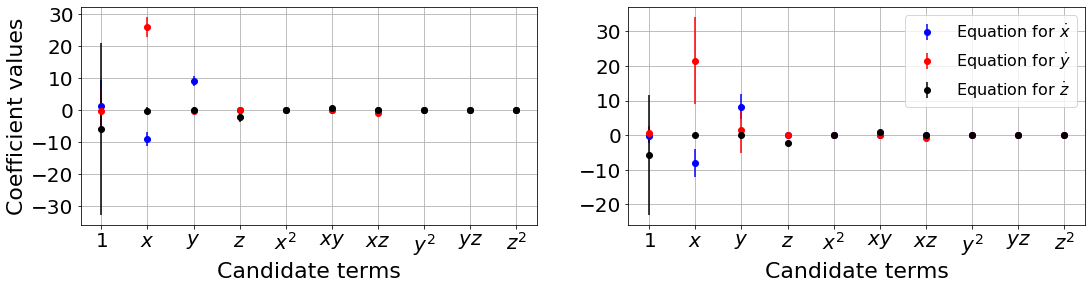

In [17]:
plot_ensemble_results(
    model, 
    mean_ensemble, 
    std_ensemble, 
    mean_library_ensemble, 
    std_library_ensemble
)

### Primary conclusions of part 2c
Ensembling and library ensembling techniques generate many models, allowing for probabilistic system identification and significant robustness against noise in the data.

### Part 2d: use prior physical knowledge to constrain the model

SR3 model, no constraints:
(x)' = 1.142 1 + -9.356 x + 9.458 y + -0.064 z
(y)' = -1.961 1 + 26.407 x + -0.561 y + 0.092 z + -0.963 x z
(z)' = -0.424 1 + 0.018 x + -0.052 y + -2.584 z + 0.978 x y
ConstrainedSR3 model, equality constraints:
(x)' = 7.181 1 + -7.396 x + 7.396 y + -0.155 z
(y)' = 4.410 1 + 27.500 x + -0.614 y + -0.391 z + -0.504 x z
(z)' = 11.340 1 + 3.995 x + -2.201 y + -3.983 z + 0.561 x y


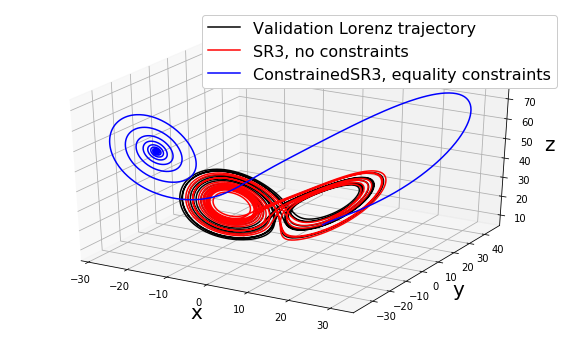

ConstrainedSR3 model, inequality constraints:
(x)' = 8.319 1 + -7.036 x + 7.536 y + -0.747 z + -0.027 x^2 + 0.057 x y + -0.076 x z + -0.029 y^2 + 0.068 y z + 0.014 z^2
(y)' = 5.460 1 + 23.951 x + 1.299 y + -0.865 z + -0.197 x^2 + 0.209 x y + -0.892 x z + -0.061 y^2 + -0.059 y z + 0.032 z^2
(z)' = 11.844 1 + 4.496 x + -2.701 y + -4.483 z + -0.239 x^2 + 1.061 x y + -0.128 x z + 0.052 y^2 + 0.080 y z + 0.059 z^2


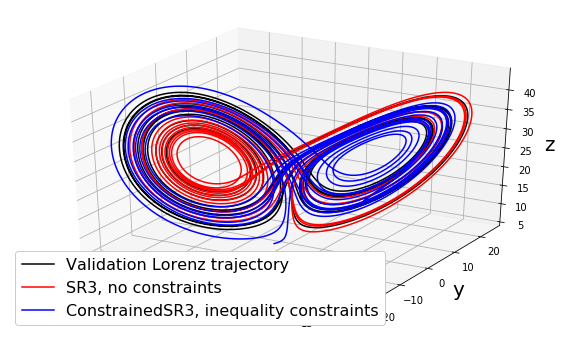

In [18]:
# Fit a regular SINDy model with 5% added Gaussian noise
sparse_regression_optimizer = ps.SR3(threshold=0.5)
model = ps.SINDy(feature_names=feature_names, optimizer=sparse_regression_optimizer)
model.fit(x_train_added_noise, t=dt)
print("SR3 model, no constraints:")
model.print()
x_sim = model.simulate(x0_test, t=t_test)

# Figure out how many library features there will be
library = ps.PolynomialLibrary()
library.fit(x_train)
n_features = library.n_output_features_

# Set constraints
n_targets = x_train.shape[1]
constraint_rhs = np.array([0, 28])

# One row per constraint, one column per coefficient
constraint_lhs = np.zeros((2, n_targets * n_features))

# 1 * (x0 coefficient) + 1 * (x1 coefficient) = 0
constraint_lhs[0, 1] = 1
constraint_lhs[0, 2] = 1

# 1 * (x0 coefficient) = 28
constraint_lhs[1, 1 + n_features] = 1

optimizer = ps.ConstrainedSR3(
    constraint_rhs=constraint_rhs,
    constraint_lhs=constraint_lhs,
    threshold=0.5,
    thresholder="l1",
)
model = ps.SINDy(
    optimizer=optimizer, feature_library=library, feature_names=feature_names
)
model.fit(x_train_added_noise, t=dt)
print("ConstrainedSR3 model, equality constraints:")
model.print()
constrained_x_sim = model.simulate(x0_test, t=t_test)
make_3d_plots(x_test, x_sim, constrained_x_sim, 
              "ConstrainedSR3, equality constraints")

# Repeat with inequality constraints
eps = 0.5
constraint_rhs = np.array([eps, eps, 28])

# One row per constraint, one column per coefficient
constraint_lhs = np.zeros((3, n_targets * n_features))

# 1 * (x0 coefficient) + 1 * (x1 coefficient) <= eps
constraint_lhs[0, 1] = 1
constraint_lhs[0, 2] = 1

# -eps <= 1 * (x0 coefficient) + 1 * (x1 coefficient)
constraint_lhs[1, 1] = -1
constraint_lhs[1, 2] = -1

# 1 * (x0 coefficient) <= 28
constraint_lhs[2, 1 + n_features] = 1

optimizer = ps.ConstrainedSR3(
    constraint_rhs=constraint_rhs,
    constraint_lhs=constraint_lhs,
    threshold=0.5,
    inequality_constraints=True,
    thresholder="l1",
)
model = ps.SINDy(
    optimizer=optimizer, feature_library=library, feature_names=feature_names
)
model.fit(x_train_added_noise, t=dt)
print("ConstrainedSR3 model, inequality constraints:")
model.print()
constrained_x_sim = model.simulate(x0_test, t=t_test)
make_3d_plots(
    x_test, x_sim, constrained_x_sim, 
    "ConstrainedSR3, inequality constraints"
)

### Primary conclusions of part 2d
Physical priors can be built into data-driven models via equality or inequality constraints. This restricts the possible solutions, which can improve robustness against noise. However, there are some pitfalls, such as above where we restrict the coefficients of x and y to be equal and opposite with equality constraints. Inequality constraints are often more suitable. 

### Part 2e (advanced): use trapping SINDy for globally stable models

In [19]:
# define hyperparameters
threshold = 0
max_iter = 20000
eta = 1.0e-2
constraint_zeros, constraint_matrix = make_constraints(3)

# run trapping SINDy
sindy_opt = ps.TrappingSR3(
    threshold=threshold,
    eta=eta,
    gamma=-1,
    max_iter=max_iter,
    constraint_lhs=constraint_matrix,
    constraint_rhs=constraint_zeros,
    constraint_order="feature",
)

# Initialize quadratic SINDy library, with custom ordering
library_functions = [lambda x: x, lambda x, y: x * y, lambda x: x ** 2]
library_function_names = [lambda x: x, lambda x, y: x + y, lambda x: x + x]
sindy_library = ps.CustomLibrary(
    library_functions=library_functions, 
    function_names=library_function_names
)

model = ps.SINDy(
    optimizer=sindy_opt,
    feature_library=sindy_library,
)
model.fit(x_train, t=dt, quiet=True)
model.print()

Xi = model.coefficients().T
check_stability(3, Xi, sindy_opt)

 Iteration | Data Error | Stability Error |   L1 Error
           0  1.77807e+03  1.27912e+04  0.00000e+00
        2000  1.12368e+03  3.53795e+01  0.00000e+00
        4000  1.20566e+03  5.13142e+00  0.00000e+00
        6000  1.21581e+03  1.77773e+00  0.00000e+00
        8000  1.21300e+03  8.53648e-01  0.00000e+00
       10000  1.20694e+03  4.85209e-01  0.00000e+00
       12000  1.20018e+03  3.05556e-01  0.00000e+00
       14000  1.19352e+03  2.06107e-01  0.00000e+00
       16000  1.18723e+03  1.46035e-01  0.00000e+00
       18000  1.18139e+03  1.07360e-01  0.00000e+00
(x0)' = -9.528 x0 + 9.741 x1 + -0.050 x2 + -0.020 x0x1 + -0.012 x0x2 + 0.006 x1x2 + 0.014 x1x1 + 0.002 x2x2
(x1)' = 27.321 x0 + -0.576 x1 + 0.056 x2 + -0.014 x0x1 + -0.981 x0x2 + -0.012 x1x2 + 0.020 x0x0 + -0.002 x2x2
(x2)' = 0.076 x0 + -0.074 x1 + -2.676 x2 + 0.975 x0x1 + -0.002 x0x2 + 0.002 x1x2 + 0.012 x0x0 + 0.012 x1x1
optimal m:  [-0.79056771 -0.0781918  36.65605567]
As eigvals:  [-10.01507412  -2.67655747  -0.959695

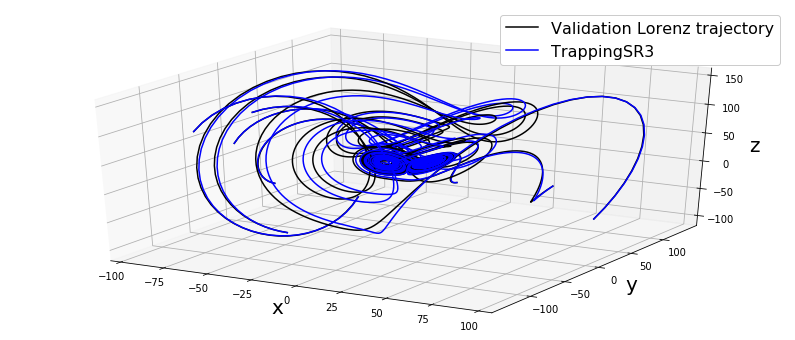

In [20]:
# show that new model trajectories are all stable
fig = plt.figure(figsize=(14, 6))
ax = fig.add_subplot(111, projection="3d")
for i in range(10):
    x0_new = (np.random.rand(3) - 0.5) * 200
    x_test_new = solve_ivp(
        lorenz, t_test_span, x0_new, t_eval=t_test, **integrator_keywords
    ).y.T
    ax.plot(x_test_new[:, 0], x_test_new[:, 1], x_test_new[:, 2], "k")
    x_test_pred_new = model.simulate(x0_new, t=t_test, integrator="odeint")
    plt.plot(x_test_pred_new[:, 0], x_test_pred_new[:, 1], 
             x_test_pred_new[:, 2], "b")
    ax.set_xlabel("x", fontsize=20)
    ax.set_ylabel("y", fontsize=20)
    ax.set_zlabel("z", fontsize=20)
    plt.legend(
        ["Validation Lorenz trajectory", "TrappingSR3"], 
        fontsize=16, framealpha=1.0
    )

### Primary conclusions of part 2e
Trapping SINDy can provide models that are provably globally stable for any new initial condition. However, the system must have energy-preserving quadratic nonlinearities. These types of systems are common in fluid and plasma flows.

Last thing we haven't covered here... trimming outliers can really help for some noisy datasets. The ConstrainedSR3 optimizer allows for automated trimming, but there are many methods for pre-processing data to remove outliers before solving the SINDy optimization. 

### Part 2f (advanced): use the weak formulation of SINDy

Normal SINDy result on 10% Lorenz noise: 
(x)' = 42.470 1 + -2.350 x + 7.009 y + -2.866 z + 0.218 x^2 + 0.311 x y + -0.131 x z + -0.232 y^2
(y)' = 9.413 1 + -0.623 x + 13.814 y + 0.556 z + -0.358 x^2 + 0.959 x y + -0.294 x z + -0.530 y^2 + -0.272 y z
(z)' = 33.913 1 + -15.720 x + 8.818 y + -3.430 z + 0.305 x^2 + 0.348 x y + 0.438 x z + 0.133 y^2 + -0.273 y z
Weak form result on 10% Lorenz noise: 
(x)' = -9.807 x + 9.830 y
(y)' = -3.444 1 + 27.902 x + -1.033 y + 0.162 z + -0.999 xz
(z)' = -1.673 1 + -0.356 x + 0.175 y + -2.586 z + 1.003 xy


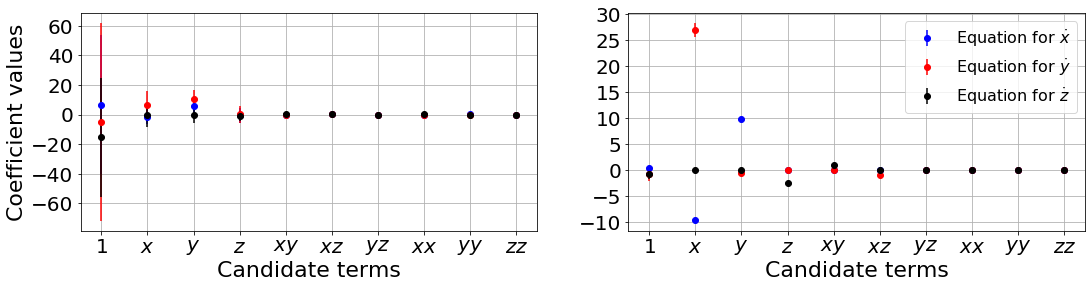

In [21]:
ode_lib = ps.WeakPDELibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    spatiotemporal_grid=t_train,
    include_bias=True,
)
rmse = mean_squared_error(x_train, np.zeros(x_train.shape), squared=False)
x_train_added_noise = x_train + np.random.normal(0, rmse / 10.0, x_train.shape)

# Fit a normal SINDy model
optimizer = ps.STLSQ()
model = ps.SINDy(feature_names=feature_names, optimizer=optimizer)
model.fit(x_train_added_noise, t=dt, ensemble=True)

print("Normal SINDy result on 10% Lorenz noise: ")
model.print()
regular_models = model.coef_list
regular_mean = np.mean(regular_models, axis=0)
regular_std = np.std(regular_models, axis=0)

# Instantiate and fit a weak formulation SINDy model
optimizer = ps.STLSQ()
model = ps.SINDy(
    feature_library=ode_lib, 
    feature_names=feature_names, 
    optimizer=optimizer
)
model.fit(x_train_added_noise, t=dt, ensemble=True)
print("Weak form result on 10% Lorenz noise: ")
model.print()
weak_form_models = model.coef_list
weak_form_mean = np.mean(weak_form_models, axis=0)
weak_form_std = np.std(weak_form_models, axis=0)

plot_ensemble_results(model, regular_mean, regular_std, 
                      weak_form_mean, weak_form_std)

### Primary conclusions of part 2f
The weak formulation of SINDy drastically improves the quality of the models when noise is present, and can be used with ensembling methods for extra robustness against high noise levels. 

# Part 3a: Implicit ODEs

## Implicit ODEs 
How would we use SINDy to solve an implicit ODE? In other words, now the RHS can depend on x and x_dot, 
$$\dot{\mathbf{x}} = \mathbf{f}(\mathbf{x}, \dot{\mathbf{x}})$$


In order to deal with this, we need a library $\Theta(\mathbf{x}, \dot{\mathbf{x}})$. SINDy parallel implicit (SINDy-PI) is geared to solve these problems. It solves the optimization problem,
$$argmin_\mathbf{\Xi} (\|\Theta(\mathbf{X}, \dot{\mathbf{X}}) - \Theta(\mathbf{X}, \dot{\mathbf{X}})\mathbf{\Xi}\| + \lambda \|\mathbf{\Xi}\|_1)$$
such that diag$(\mathbf{\Xi}) = 0$. See the [SINDy-PI notebook](https://github.com/dynamicslab/pysindy/blob/master/examples/9_sindypi_with_sympy.ipynb) for more details. 

Here we illustrate successful identification of the 1D Michelson-Menten enzyme model
$$\dot{x} = 0.6 - \frac{1.5 x}{0.3 + x}.$$
Or, equivalently
$$\dot{x} = 0.6 - 3 x - \frac{10}{3} x\dot{x}.$$

In [22]:
# define parameters
r = 1
dt = 0.001
T = 4
t = np.arange(0, T + dt, dt)
t_span = (t[0], t[-1])
x0_train = [0.55]
x_train = solve_ivp(enzyme, t_span, x0_train, t_eval=t, **integrator_keywords).y.T

# Initialize custom SINDy library
x_library_functions = [
    lambda x: x,
    lambda x, y: x * y,
    lambda x: x ** 2,
]
x_dot_library_functions = [lambda x: x]

# library function names includes both the 
# x_library_functions and x_dot_library_functions names.
library_function_names = [
    lambda x: x,
    lambda x, y: x + y,
    lambda x: x + x,
    lambda x: x,
]

# Need to pass time base to the library
sindy_library = ps.SINDyPILibrary(
    library_functions=x_library_functions,
    x_dot_library_functions=x_dot_library_functions,
    t=t[1:-1],
    function_names=library_function_names,
    include_bias=True,
)

# Use the SINDy-PI optimizer, which relies on CVXPY.
sindy_opt = ps.SINDyPI(
    threshold=1e-6,
    tol=1e-8,
    max_iter=20000,
)
model = ps.SINDy(
    optimizer=sindy_opt,
    feature_library=sindy_library,
    differentiation_method=ps.FiniteDifference(drop_endpoints=True),
    feature_names=["x"],
)
model.fit(x_train, t=t)
model.print()

1 = 5.000 x + 1.667 x_dot + 5.556 xx_dot
x = 0.200 1 + -0.333 x_dot + -1.111 xx_dot
xx = 0.200 x + -0.333 xx_dot + -1.111 xxx_dot
x_dot = 0.600 1 + -3.000 x + -3.333 xx_dot
xx_dot = 0.180 1 + -0.900 x + -0.300 x_dot
xxx_dot = 0.180 x + -0.900 xx + -0.299 xx_dot


### Primary conclusions of part 3a
If the system might be best described as an implicit ODE, the SINDy-PI optimizer should be used. In contrast to the other optimizers, this optimizer generates a model for *each and every candidate library term*. It is up to the user to choose which model to use.

# Part 3b: Identifying partial differential equations (PDEs)

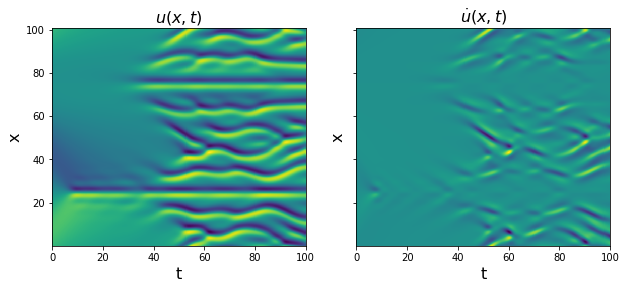

In [23]:
from scipy.io import loadmat

# Load data from .mat file
data = loadmat('data/kuramoto_sivishinky.mat')
t = np.ravel(data['tt'])
dt = t[1] - t[0]
x = np.ravel(data['x'])
u = data['uu']
u = u.reshape(len(x), len(t), 1)
u_dot = plot_u_and_u_dot(t, x, u)

In [24]:
# Define PDE library that is quadratic in u, 
# and fourth-order in spatial derivatives of u.
library_functions = [lambda x: x, lambda x: x * x]
library_function_names = [lambda x: x, lambda x: x + x]
pde_lib = ps.PDELibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    derivative_order=4,
    spatial_grid=x,
    is_uniform=True,
)

# Again, loop through all the optimizers
print('STLSQ model: ')
optimizer = ps.STLSQ(threshold=30, normalize_columns=True)
model = ps.SINDy(feature_library=pde_lib, 
                 feature_names=['u'], 
                 optimizer=optimizer)
model.fit(u, t=dt)
model.print()

STLSQ model: 
(u)' = -0.994 u_11 + -0.996 u_1111 + -0.992 uu_1


### Primary conclusions of section 3b
PDE identification can be done straightforwardly with PDELibrary. The primary changes are flattening the data, passing x_dot to model.fit, and defining a spatial grid for the PDE.

# Part 4: How to choose a regularizer and a sparse regression algorithm?
This table summarizes the optimizers available in PySINDy. Note that TrappingSR3 and SINDyPI are both geared for very specific dynamical systems, so we will only investigate the remaining optimizers.
![title](data/optimizer_summary.jpg)
### Okay so how do you choose between, for instance, using the $l_0$ and $l_1$ regularizers? And once that choice is made, which algorithm should you use to solve the problem?
#### Advantages and disadvantages of $l_0$: 
Using the $l_0$ norm typically produces sparser solutions than using the $l_1$ norm. This tends to further lead to higher performance and more stable models, since there are no small-coefficient terms that can become active with new initial conditions or parameter regimes. The downside is that the $l_0$ norm transforms the SINDy regression into a nonconvex problem, for which only local convergence guarantees can be provided. <br>
#### Advantages and disadvantages of $l_1$: 
Can be used with (in)equality constraints, problem is convex so have global convergence guarantees. The downside is that sparsity is harder to enforce, and the $l_1$ norm can systematically bias the system towards certain solutions. 

### Part 4a: Choosing an algorithm to solve the $l_0$ problem

In [25]:
# redefine the testing and training Lorenz data we will use for these examples
dt = .002

t_train = np.arange(0, 10, dt)
x0_train = [-8, 8, 27]
t_train_span = (t_train[0], t_train[-1])
x_train = solve_ivp(lorenz, t_train_span, x0_train, 
                    t_eval=t_train, **integrator_keywords).y.T

t_test = np.arange(0, 15, dt)
t_test_span = (t_test[0], t_test[-1])
x0_test = np.array([8, 7, 15])
x_test = solve_ivp(lorenz, t_test_span, x0_test, 
                   t_eval=t_test, **integrator_keywords).y.T

In [26]:
rmse = mean_squared_error(x_train, np.zeros(x_train.shape), squared=False)
x_train_added_noise = x_train + np.random.normal(0, rmse / 10.0,  x_train.shape)

stlsq_optimizer = ps.STLSQ(threshold=0.5)
ssr_optimizer = ps.SSR()
# Note FROLS is similar to least-angle regression (LARS) 
# and Orthogonal Matching Pursuit (OMP).
frols_optimizer = ps.FROLS()

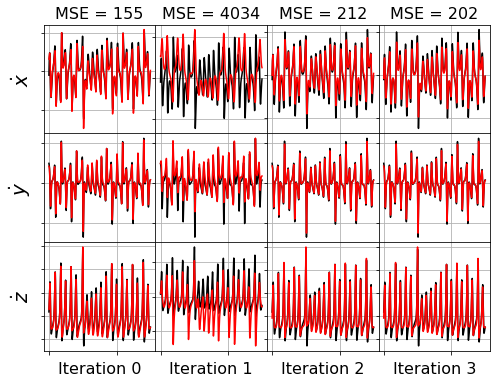

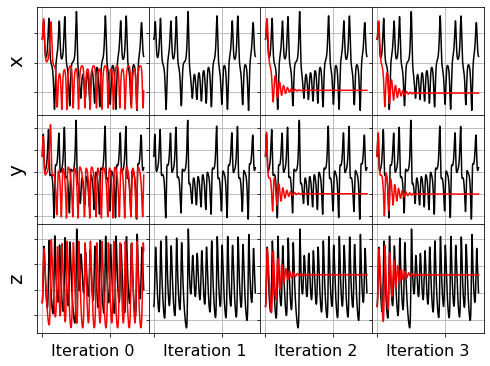

In [27]:
model = ps.SINDy(optimizer=stlsq_optimizer)
model.fit(x_train_added_noise, t=dt)
plot_x_dot_fits(x_test, stlsq_optimizer, dt, 10)
plot_x_fits(x_test, stlsq_optimizer, t_test, 10)

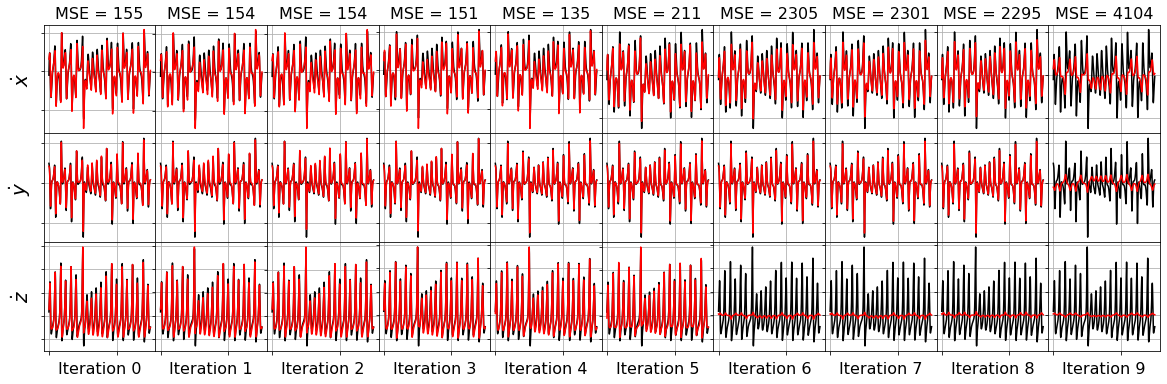

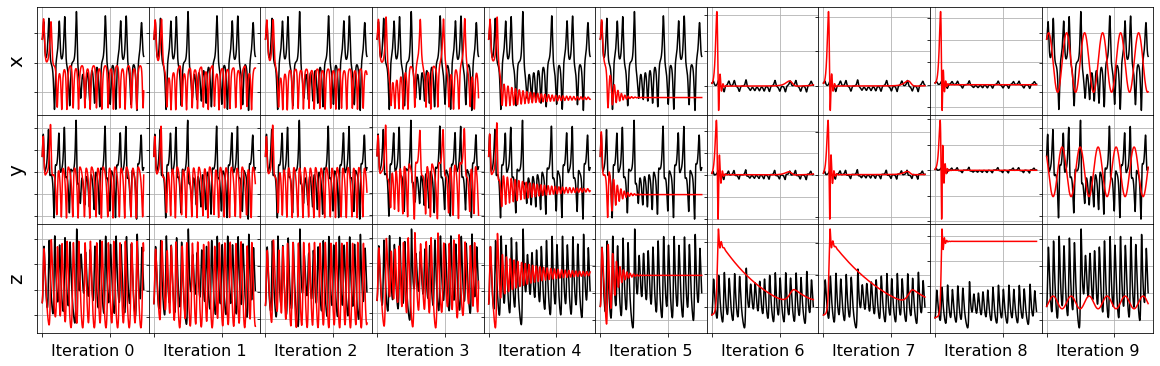

In [28]:
model = ps.SINDy(optimizer=ssr_optimizer)
model.fit(x_train_added_noise, t=dt)
plot_x_dot_fits(x_test, ssr_optimizer, dt, 10)
plot_x_fits(x_test, ssr_optimizer, t_test, 10)

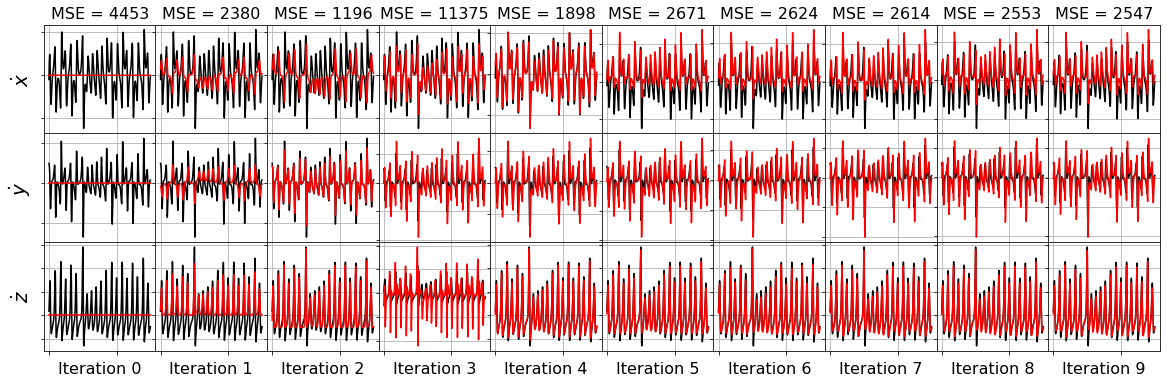

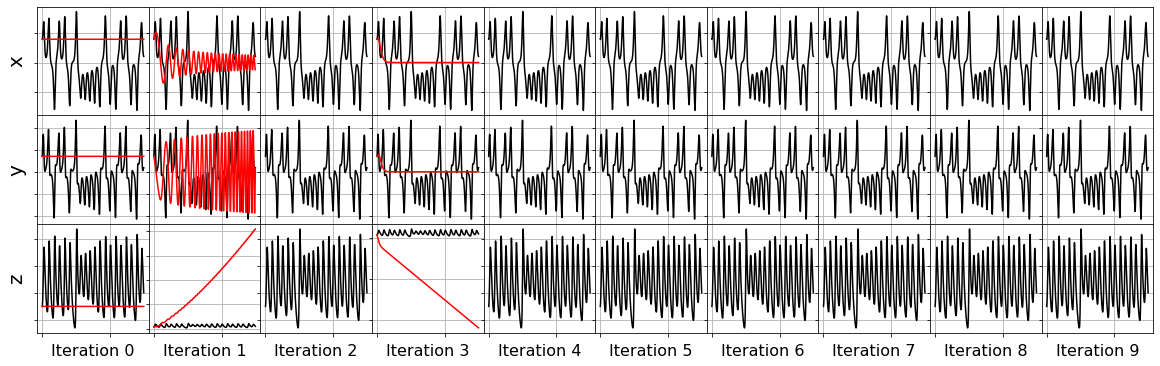

In [29]:
model = ps.SINDy(optimizer=frols_optimizer)
model.fit(x_train_added_noise, t=dt)
plot_x_dot_fits(x_test, frols_optimizer, dt, 10)
plot_x_fits(x_test, frols_optimizer, t_test, 10)

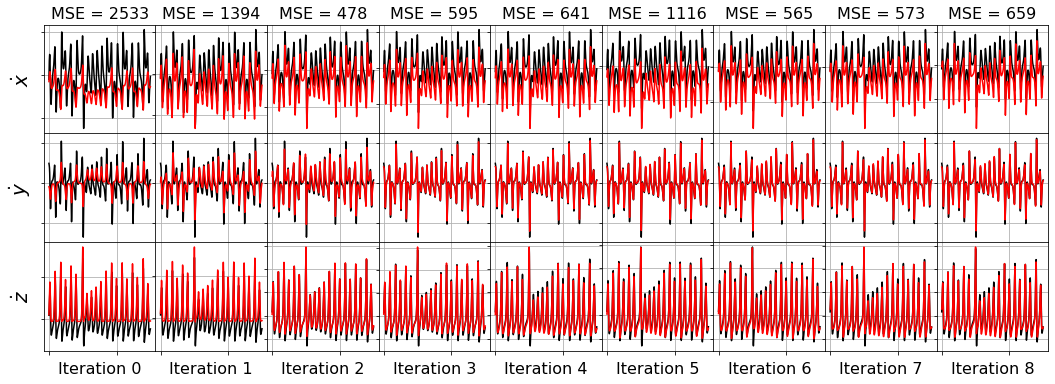

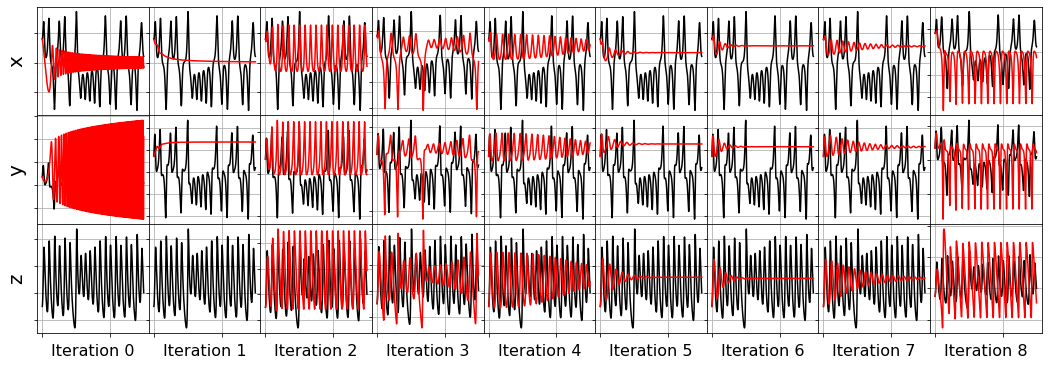

In [30]:
# Least-angle regression (LARS), 
# linear regression such that ||coefs||_0 <= n_nonzero
history_ = []
for i in range(1, n_features):
    lars_optimizer = Lars(n_nonzero_coefs=i)
    model = ps.SINDy(optimizer=lars_optimizer)
    model.fit(x_train_added_noise, t=dt)
    history_.append(lars_optimizer.coef_)

lars_optimizer.history_ = history_
plot_x_dot_fits(x_test, lars_optimizer, dt, 10)
plot_x_fits(x_test, lars_optimizer, t_test, 10)

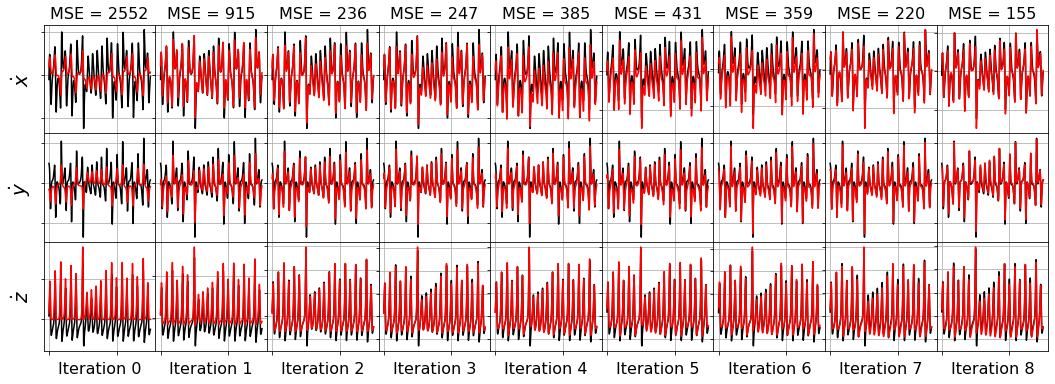

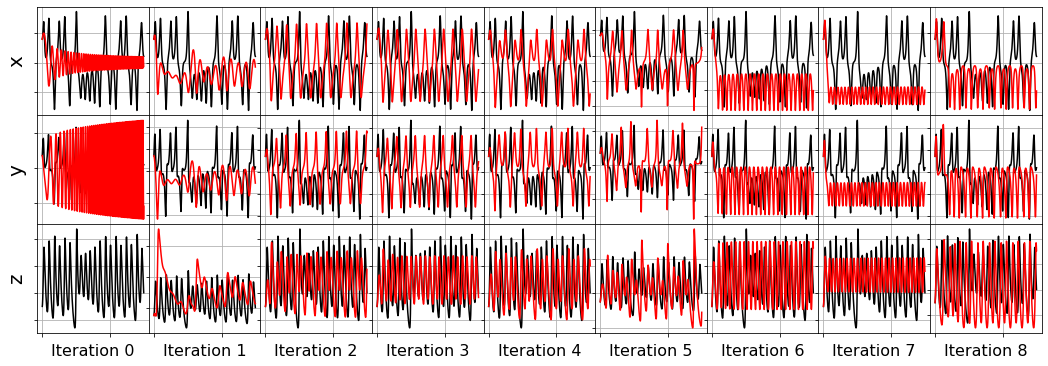

In [31]:
# Orthogonal matching pursuit (OMP) regression, 
# linear regression such that ||coefs||_0 <= n_nonzero.
history_ = []
for i in range(1, n_features):
    omp_optimizer = OrthogonalMatchingPursuit(n_nonzero_coefs=i)
    model = ps.SINDy(optimizer=omp_optimizer)
    model.fit(x_train_added_noise, t=dt)
    history_.append(omp_optimizer.coef_)

omp_optimizer.history_ = history_
plot_x_dot_fits(x_test, omp_optimizer, dt, 10)
plot_x_fits(x_test, omp_optimizer, t_test, 10)

### Primary conclusions of part 4a
The STLSQ and SSR optimizers are more robust against noisy data than the FROLs, OMP, or LARS optimizers because the latter algorithms rely on choosing terms by computing correlations with the target data. SSR should be used if avoiding the user wants to avoid hyperparameters or if the user wants a specific technique for chopping off coefficients at each algorithm iteration. For instance, STLSQ also zeros out the coefficients below the threshold value, and then refits the coefficients. SSR can zero out coefficients with more complex criteria. 

### Part 4b: Choosing an algorithm to solve the $l_1$ problem
Built-in sklearn functions can be used to perform sparse regression with the $l_1$ norm. However, they typically lack some of the functionality of the $l_1$ norm PySINDy optimizers.

In [32]:
optimizers = []

# Linear regression, no sparsity promotion
optimizers.append(LinearRegression())

# Lasso regression with the l1 norm, here "alpha" is rescaled version of the PySINDy "lambda"
optimizers.append(Lasso(alpha=2))

# LassoLars regression, i.e. the Lasso problem solves with the LARS algorithm
optimizers.append(LassoLars(alpha=0.01))

# Ridge regression with the l2 norm, here "alpha" is same as the PySINDy "alpha"
optimizers.append(Ridge(alpha=2))

# ElasticNet regression with combination of the l1 and l2 norms
optimizers.append(ElasticNet(alpha=2, l1_ratio=0.5))

# SR3 regression with the l1 norm
optimizers.append(ps.SR3(threshold=0.2))

model_type = ['LinearRegression', 'Lasso', 'LassoLARS', 
              'Ridge', 'ElasticNet', 'SR3']
for i, opt in enumerate(optimizers):
    print(model_type[i] + ' model:')
    model = ps.SINDy(optimizer=opt, feature_names=feature_names)
    model.fit(x_train, t=dt, quiet=True)
    model.print()

LinearRegression model:
(x)' = -10.005 x + 10.003 y + -0.001
(y)' = 27.991 x + -0.998 y + 0.002 z + -1.000 x z + -0.015
(z)' = 0.006 x + -0.004 y + -2.666 z + 0.001 x^2 + 0.999 x y + 0.008
Lasso model:
(x)' = -10.005 x + 10.003 y + -1.498
(y)' = 27.991 x + -0.997 y + -1.000 x z + 0.609
(z)' = -2.667 z + 0.001 x^2 + 0.999 x y + -18.674
LassoLARS model:
(x)' = -10.005 x + 10.003 y + -0.983
(y)' = 27.990 x + -0.997 y + -1.000 x z + 2.280
(z)' = -2.666 z + 1.000 x y + -2.940
Ridge model:
(x)' = -10.005 x + 10.003 y + -0.016
(y)' = 27.991 x + -0.998 y + 0.002 z + -1.000 x z + 0.005
(z)' = 0.006 x + -0.004 y + -2.666 z + 0.001 x^2 + 0.999 x y + -0.003
ElasticNet model:
(x)' = 4.061 y + 0.063 x^2 + -0.122 x y + -0.274 x z + 0.060 y^2 + 0.162 y z + -0.004 z^2 + -1.271
(y)' = 27.991 x + -0.997 y + -1.000 x z + 2.223
(z)' = -2.667 z + 0.001 x^2 + 0.999 x y + -16.643
SR3 model:
(x)' = -9.999 x + 9.999 y
(y)' = 27.992 x + -0.999 y + -1.000 x z
(z)' = -2.666 z + 1.000 x y


### Primary conclusions of part 4b
All the optimizers work pretty well, but the $l_1$ norm tends to produce a few very small "extra" terms that are hard to truncate unless the hyperparameter $\lambda$ is tuned. The PySINDy SR3 optimizer works very well, can be easily updated to allow for some $l_2$ norm regularization, has robust convergence guarantees, and allows for equality and inequality constraints, so we strongly recommend the use of this optimizer with the $l_1$ norm. However, depending on the dynamical system, one may also need to tune the additional hyperparameter $\nu$ (usually $\nu =1$ is fine), and this is the primary downside of this method.

# Part 5: How to build complex candidate libraries

### Concatenate two libraries
Two or more libraries can be combined via the `+` operator.

In [33]:
identity_library = ps.IdentityLibrary()
fourier_library = ps.FourierLibrary()
combined_library = identity_library + fourier_library

model = ps.SINDy(feature_library=combined_library, feature_names=feature_names)
model.fit(x_train, t=dt)
model.get_feature_names()

['x',
 'y',
 'z',
 'sin(1 x)',
 'cos(1 x)',
 'sin(1 y)',
 'cos(1 y)',
 'sin(1 z)',
 'cos(1 z)']

### Tensor two libraries together
Two or more libraries can be tensored together via the `*` operator.

In [34]:
poly_library = ps.PolynomialLibrary(include_bias=False)
fourier_library = ps.FourierLibrary()
combined_library = poly_library * fourier_library

model = ps.SINDy(feature_library=combined_library, feature_names=feature_names)
model.fit(x_train, t=dt)
model.get_feature_names()

['x sin(1 x)',
 'x cos(1 x)',
 'x sin(1 y)',
 'x cos(1 y)',
 'x sin(1 z)',
 'x cos(1 z)',
 'y sin(1 x)',
 'y cos(1 x)',
 'y sin(1 y)',
 'y cos(1 y)',
 'y sin(1 z)',
 'y cos(1 z)',
 'z sin(1 x)',
 'z cos(1 x)',
 'z sin(1 y)',
 'z cos(1 y)',
 'z sin(1 z)',
 'z cos(1 z)',
 'x^2 sin(1 x)',
 'x^2 cos(1 x)',
 'x^2 sin(1 y)',
 'x^2 cos(1 y)',
 'x^2 sin(1 z)',
 'x^2 cos(1 z)',
 'x y sin(1 x)',
 'x y cos(1 x)',
 'x y sin(1 y)',
 'x y cos(1 y)',
 'x y sin(1 z)',
 'x y cos(1 z)',
 'x z sin(1 x)',
 'x z cos(1 x)',
 'x z sin(1 y)',
 'x z cos(1 y)',
 'x z sin(1 z)',
 'x z cos(1 z)',
 'y^2 sin(1 x)',
 'y^2 cos(1 x)',
 'y^2 sin(1 y)',
 'y^2 cos(1 y)',
 'y^2 sin(1 z)',
 'y^2 cos(1 z)',
 'y z sin(1 x)',
 'y z cos(1 x)',
 'y z sin(1 y)',
 'y z cos(1 y)',
 'y z sin(1 z)',
 'y z cos(1 z)',
 'z^2 sin(1 x)',
 'z^2 cos(1 x)',
 'z^2 sin(1 y)',
 'z^2 cos(1 y)',
 'z^2 sin(1 z)',
 'z^2 cos(1 z)']

### Generalized library

Create the most general and flexible possible library by combining and tensoring as many libraries as you want, and you can even specify which input variables to use to generate each library! 

Note that using this is a more advanced feature, but with the benefit that it allows any SINDy library you want.

In [35]:
# Initialize three libraries
poly_library = ps.PolynomialLibrary()
fourier_library = ps.FourierLibrary()
library_functions = [lambda x: 1.0 / (x + 100), lambda x: np.exp(-x)]
library_function_names = [
    lambda x: "1.0 / (" + x + " + 100)",
    lambda x: "exp(-" + x + ")",
]
custom_library = ps.CustomLibrary(
    library_functions=library_functions, 
    function_names=library_function_names
)

# Initialize the default inputs, i.e. each library
# uses all the input variables, (5 inputs and 3 libraries here)
inputs_temp = np.tile([0, 1, 2, 3, 4], 3)
inputs_per_library = np.reshape(inputs_temp, (3, 5))

# Don't use the x, u0, u1 inputs for generating the Fourier library
inputs_per_library[1, 2] = 1
inputs_per_library[1, 3] = 1
inputs_per_library[1, 4] = 1

# Don't use the y, z, u0 inputs for generating the custom library
inputs_per_library[2, 1] = 0
inputs_per_library[2, 2] = 0
inputs_per_library[2, 3] = 0
print(inputs_per_library)

# Tensor all the polynomial and Fourier library terms together
# and tensor all the Fourier and Custom library terms together.
tensor_array = [[1, 1, 0], [0, 1, 1]]

# Initialize this generalized library, all the work hidden from the user!
generalized_library = ps.GeneralizedLibrary(
    [poly_library, fourier_library, custom_library],
    tensor_array=tensor_array,
    inputs_per_library=inputs_per_library,
)

# Fit the model and print the library feature names to check success
model = ps.SINDy(feature_library=generalized_library)
model.fit(x_train_control, u=u_train_control, t=dt, quiet=True)
model.print()
model.get_feature_names()

[[0 1 2 3 4]
 [0 1 1 1 1]
 [0 0 0 0 4]]
(x0)' = -9.999 x0 + 9.999 x1 + 0.999 u0
(x1)' = 27.988 x0 + -0.998 x1 + -1.000 x0 x2
(x2)' = -2.666 x2 + -1.000 u1 + 1.000 x0 x1


['1',
 'x0',
 'x1',
 'x2',
 'u0',
 'u1',
 'x0^2',
 'x0 x1',
 'x0 x2',
 'x0 u0',
 'x0 u1',
 'x1^2',
 'x1 x2',
 'x1 u0',
 'x1 u1',
 'x2^2',
 'x2 u0',
 'x2 u1',
 'u0^2',
 'u0 u1',
 'u1^2',
 'sin(1 x0)',
 'cos(1 x0)',
 'sin(1 x1)',
 'cos(1 x1)',
 '1.0 / (x0 + 100)',
 '1.0 / (u1 + 100)',
 'exp(-x0)',
 'exp(-u1)',
 '1 sin(1 x0)',
 '1 cos(1 x0)',
 '1 sin(1 x1)',
 '1 cos(1 x1)',
 'x0 sin(1 x0)',
 'x0 cos(1 x0)',
 'x0 sin(1 x1)',
 'x0 cos(1 x1)',
 'x1 sin(1 x0)',
 'x1 cos(1 x0)',
 'x1 sin(1 x1)',
 'x1 cos(1 x1)',
 'x2 sin(1 x0)',
 'x2 cos(1 x0)',
 'x2 sin(1 x1)',
 'x2 cos(1 x1)',
 'u0 sin(1 x0)',
 'u0 cos(1 x0)',
 'u0 sin(1 x1)',
 'u0 cos(1 x1)',
 'u1 sin(1 x0)',
 'u1 cos(1 x0)',
 'u1 sin(1 x1)',
 'u1 cos(1 x1)',
 'x0^2 sin(1 x0)',
 'x0^2 cos(1 x0)',
 'x0^2 sin(1 x1)',
 'x0^2 cos(1 x1)',
 'x0 x1 sin(1 x0)',
 'x0 x1 cos(1 x0)',
 'x0 x1 sin(1 x1)',
 'x0 x1 cos(1 x1)',
 'x0 x2 sin(1 x0)',
 'x0 x2 cos(1 x0)',
 'x0 x2 sin(1 x1)',
 'x0 x2 cos(1 x1)',
 'x0 u0 sin(1 x0)',
 'x0 u0 cos(1 x0)',
 'x0 u0 si

### Primary conclusions of section 5
One can add and multiply SINDy feature libraries together straightforwardly. The GeneralizedLibrary class allows for very general libraries, arbitrary tensor products between the libraries, and specific input variables, control variables, etc. for each library. This is a very useful feature for PDEs and systems with control inputs, which can have candidate terms that depend on the data variables, the data variable spatiotemporal derivatives, the control inputs, the spatiotemporal coordinates, and so on. 